# Measuring the potential for internal priming in Nanopore reads

Does nanopore data suffer from internal priming in the same way as Illumina?

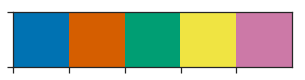

In [1]:
import sys
import os
import re
from glob import glob
import random
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pyBigWig as pybw
import pysam

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=2, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
FASTA = '/cluster/ggs_lab/mtparker/Arabidopsis_annotations/TAIR10/ensembl/release_35/Arabidopsis_thaliana.TAIR10.dna.toplevel.fa'

with pysam.FastaFile(FASTA) as fasta, open('polya_sites.bed', 'w') as polya:
    for chrom in fasta.references:
        seq = fasta.fetch(chrom)
        for polya_site in re.finditer('(A{6})|(T{6})', seq):
            strand = '+' if polya_site.group(1) else '-'
            start = polya_site.start()
            end = polya_site.end()
            polya.write(f'{chrom}\t{start}\t{end}\tpolya\t.\t{strand}\n')

In [3]:
!head polya_sites.bed

1	194	200	polya	.	-
1	630	636	polya	.	+
1	691	697	polya	.	+
1	754	760	polya	.	-
1	1154	1160	polya	.	-
1	1198	1204	polya	.	+
1	1343	1349	polya	.	-
1	1969	1975	polya	.	+
1	2082	2088	polya	.	-
1	2358	2364	polya	.	-


In [4]:
!bedtools getfasta -s -fi {FASTA} -bed polya_sites.bed -fo stdout | head

>1:194-200(-)
AAAAAA
>1:630-636(+)
AAAAAA
>1:691-697(+)
AAAAAA
>1:754-760(-)
AAAAAA
>1:1154-1160(-)
AAAAAA


In [5]:
%%bash

ARAPORT='/cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_GFF3_genes_transposons.201606.no_chr.gtf'

bedtools intersect -s -f 1 -u \
  -a polya_sites.bed \
  -b <(awk '$3 == "CDS"' $ARAPORT) |
bedtools intersect -v -s \
  -a stdin \
  -b <(awk '$3 == "3UTR"' $ARAPORT) > polya_cds.bed
wc -l polya_cds.bed

10116 polya_cds.bed


In [6]:
def parse_exons(record):
    start = int(record[1])
    end = int(record[2])
    exstarts = np.fromstring(record[11], sep=',') + start
    exends = exstarts + np.fromstring(record[10], sep=',')
    exons = np.dstack([exstarts, exends])[0]
    return exons


def get_last_exon(record, flanksize=200):
    chrom = record[0].replace('Chr', '')
    strand = record[5]
    exons = parse_exons(record)
    if strand == '+':
        last_exon = exons[-1]
    else:
        last_exon = exons[0]
    return chrom, last_exon[0], last_exon[1], strand
    

In [7]:
last_exons = []
with open('/cluster/ggs_lab/mtparker/Arabidopsis_annotations/Araport/v11/201606/Araport11_protein_coding.201606.bed') as bed:
    for record in bed:
        last_exons.append(get_last_exon(record.split()))
last_exons = pd.DataFrame(last_exons, columns=['chrom', 'start', 'end', 'strand'])
last_exons.head()

,chrom,start,end,strand
0,1,5438.0,5899.0,+
1,1,6787.0,7069.0,-
2,1,6787.0,7069.0,-
3,1,6787.0,7069.0,-
4,1,6787.0,7069.0,-


In [8]:
fwd_bws = [
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/TAIR10/201901_col0_2916_fwd_three-prime.bigwig',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/aligned_data/TAIR10/201901_col0_2917_fwd_three-prime.bigwig',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/TAIR10/201901_col0_2918_fwd_three-prime.bigwig',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/aligned_data/TAIR10/201901_col0_2919_fwd_three-prime.bigwig',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180405_FAH59362_WT_Col0_2917/aligned_data/TAIR10/201903_col0_2917_exp2_fwd_three-prime.bigwig'
]
fwd_bws = [pybw.open(fn) for fn in fwd_bws]

rev_bws = [
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180201_1617_20180201_FAH45730_WT_Col0_2916_regular_seq/aligned_data/TAIR10/201901_col0_2916_rev_three-prime.bigwig',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180413_1558_20180413_FAH77434_mRNA_WT_Col0_2917/aligned_data/TAIR10/201901_col0_2917_rev_three-prime.bigwig',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180416_1534_20180415_FAH83697_mRNA_WT_Col0_2918/aligned_data/TAIR10/201901_col0_2918_rev_three-prime.bigwig',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180418_1428_20180418_FAH83552_mRNA_WT_Col0_2919/aligned_data/TAIR10/201901_col0_2919_rev_three-prime.bigwig',
    '/cluster/ggs_lab/mtparker/ONT_guppy_pipeline_runs/20180405_FAH59362_WT_Col0_2917/aligned_data/TAIR10/201903_col0_2917_exp2_rev_three-prime.bigwig'
]
rev_bws = [pybw.open(fn) for fn in rev_bws]

In [9]:
def has_three_prime_termination(chrom, start, end, strand, bw, w=13):
    win_start = start - w
    win_end = end + w
    three_prime_ends = bw.values(chrom, win_start, win_end, numpy=True)
    three_prime_ends[np.isnan(three_prime_ends)] = 0
    return three_prime_ends.sum()


internal_priming_counts = defaultdict(list)


with open('polya_cds.bed') as bed:
    for record in bed:
        for fwd_bw, rev_bw in zip(fwd_bws, rev_bws):
            chrom, start, end, *_, strand = record.split()
            start, end = int(start), int(end)
            bw = fwd_bw if strand == '+' else rev_bw
            ip = has_three_prime_termination(chrom, start, end, strand, bw)
            internal_priming_counts[(chrom, start, end, strand)].append(ip)
internal_priming_counts = pd.DataFrame(internal_priming_counts).T
internal_priming_counts.columns = ['2916', '2917a', '2918', '2919', '2917b']
internal_priming_counts['2917'] = internal_priming_counts.pop('2917a') + internal_priming_counts.pop('2917b')
internal_priming_counts.head()

2916  2918  2919  2917
1 5035   5041   +   0.0   0.0   0.0   0.0
  27813  27819  +   0.0   0.0   0.0   0.0
  35743  35749  -   0.0   0.0   0.0   0.0
  39233  39239  -   0.0   0.0   0.0   0.0
  100812 100818 +   0.0   0.0   0.0   0.0

In [10]:
internal_priming_counts.shape

(10116, 4)

In [11]:
is_last_exon = []
for chrom, start, end, strand in internal_priming_counts.index.to_frame().itertuples(index=False):
    if len(last_exons.query(f'chrom == "{chrom}" & strand == "{strand}" & start <= {start} & end >= {end}')):
        is_last_exon.append(True)
    else:
        is_last_exon.append(False)
internal_priming_counts['last_exon'] = is_last_exon
internal_priming_counts.head()

2916  2918  2919  2917  last_exon
1 5035   5041   +   0.0   0.0   0.0   0.0      False
  27813  27819  +   0.0   0.0   0.0   0.0      False
  35743  35749  -   0.0   0.0   0.0   0.0      False
  39233  39239  -   0.0   0.0   0.0   0.0      False
  100812 100818 +   0.0   0.0   0.0   0.0       True

In [12]:
internal_priming_counts.shape

(10116, 5)

In [13]:
internal_priming_counts[internal_priming_counts[['2916', '2917', '2918', '2919']].sum(1) > 0].shape

(160, 5)

In [14]:
len(internal_priming_counts[internal_priming_counts[['2916', '2917', '2918', '2919']].sum(1) > 0]) / len(internal_priming_counts) * 100

1.5816528272044286

In [15]:
len(internal_priming_counts[internal_priming_counts[['2916', '2917', '2918', '2919']].astype(bool).sum(1) == 1])

137

In [16]:
len(internal_priming_counts[internal_priming_counts[['2916', '2917', '2918', '2919']].astype(bool).sum(1) == 1]) / len(internal_priming_counts) * 100

1.3542902332937918

In [17]:
internal_priming_counts[(internal_priming_counts[['2916', '2917', '2918', '2919']].sum(1).astype(bool)) & internal_priming_counts.last_exon].shape

(66, 5)

In [18]:
internal_priming_counts['supported_in_all'] = internal_priming_counts[['2916', '2917', '2918', '2919']].astype(bool).sum(1) == 4 

In [19]:
internal_priming_counts[internal_priming_counts.supported_in_all]

2916  2918  2919  2917  last_exon  supported_in_all
1 25263483 25263489 +   9.0   1.0   1.0   9.0      False              True
  25834956 25834962 -   1.0   1.0   1.0   2.0       True              True
3 23133096 23133102 +   3.0   3.0   2.0   7.0       True              True
5 15473646 15473652 -   2.0   2.0   4.0   9.0      False              True